# End-to-End SageMaker-ML-Pipeline-with-Canary-Rollback

### Author: Pooya Fazeli
- **Email**: [pooya.fazeli@gmail.com](mailto:pooya.fazeli@gmail.com)
- **GitHub**: [github.com/fazeli95](https://github.com/fazeli95)

This notebook demonstrates an end-to-end machine learning pipeline using Amazon SageMaker, including model training, hyperparameter tuning, deployment, and advanced deployment strategies such as canary rollback and shadow testing. The entire workflow is captured in this notebook, with all outputs preserved.

**License**: This project is licensed under the MIT License. See the [LICENSE](https://opensource.org/licenses/MIT) file for more details.


# Importing Necessary Libraries
and initializing requirements

In [2]:
import sagemaker
import json
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
sagemaker_session = sagemaker.Session() # create  a SageMaker session
s3 = sagemaker_session.boto_session.resource("s3") #creates a resource object for interacting with Amazon S3.

region = boto3.Session().region_name
role = sagemaker.get_execution_role()

In [5]:
from sklearn.datasets import fetch_openml


data = fetch_openml(data_id=43539, as_frame=True)
print(data.values)
df = data.data
df.isna().sum()


<built-in method values of Bunch object at 0x7f800eb68d60>


Selected                0
LoanNr_ChkDgt           0
Name                    0
City                    0
State                   0
Zip                     0
Bank                    3
BankState               3
NAICS                   0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist                1
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr               2
LowDoc                  3
ChgOffDate           1405
DisbursementDate        3
DisbursementGross       0
BalanceGross            0
MIS_Status              0
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
New                     0
RealEstate              0
Portion                 0
Recession               0
daysterm                0
xx                      3
Default                 0
dtype: int64

In [7]:
print(df['Default'].unique())
df['Default'].sum()

[0 1]


686

# Feature Engineering

In [8]:


#1 we drop the selected column as it was used before to label training and testing data
df.drop(columns='Selected',inplace=True)

In [9]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
0,1004285007,SIMPLEX OFFICE SOLUTIONS,ANAHEIM,CA,92801,CALIFORNIA BANK TRUST,CA,532420,15074,2001,...,0,30000,15000,0,0,0.5,0,1080,16175.0,0
1,1004535010,DREAM HOME REALTY,TORRANCE,CA,90505,CALIFORNIA BANK TRUST,CA,531210,15130,2001,...,0,30000,15000,0,0,0.5,1,1680,17658.0,0
2,1005005006,"Winset, Inc. dba Bankers Hill",SAN DIEGO,CA,92103,CALIFORNIA BANK TRUST,CA,531210,15188,2001,...,0,30000,15000,0,0,0.5,0,1080,16298.0,0
3,1005535001,Shiva Management,SAN DIEGO,CA,92108,CALIFORNIA BANK TRUST,CA,531312,15719,2003,...,0,50000,25000,0,0,0.5,0,1080,16816.0,0
4,1005996006,"GOLD CROWN HOME LOANS, INC",LOS ANGELES,CA,91345,SBA - EDF ENFORCEMENT ACTION,CO,531390,16840,2006,...,0,343000,343000,0,1,1.0,0,7200,24103.0,0


In [10]:
#2 we drop the column chgoff as it has a lot of missing values
df.drop(columns='ChgOffDate',inplace=True)

In [11]:
#3 we drop the missing values
df.dropna(axis=0, inplace=True)
df.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
2096,9893714004,HOLLYWOOD TENTWORKS INC,PACOIMA,CA,91331,SBA - EDF ENFORCEMENT ACTION,CO,532310,16838,2006,...,0,1029000,1029000,0,1,1.00,0,7200,24103.0,0
2097,9893874006,MEGA VIDEO WIRELESS HIGHLAND,HIGHLAND,CA,92346,UNITI BANK,CA,532230,16838,2006,...,0,150000,75000,1,0,0.50,0,1800,18691.0,0
2098,9901143004,MOVING CONNECTION CARL'S TRA,EL CAJON,CA,92021,ZIONS FIRST NATIONAL BANK,UT,532120,13530,1997,...,0,99000,79200,0,1,0.80,0,9000,22545.0,0
2099,9903293007,"A.J. STUDIO RENTALS, INC.",CAMARILLO,CA,93012,CITY NATIONAL BANK,CA,532120,13531,1997,...,0,50000,40000,0,0,0.80,0,2520,16124.0,0
2100,9925643006,TAHOE MOTION PICTURE RENTALS,SUN VALLEY,CA,91352,CITY NATIONAL BANK,CA,532120,13542,1997,...,0,500000,375000,0,0,0.75,0,3600,17265.0,0


In [12]:
#4 the column 'NAICS'is a number which the first 2 numbers represent 
#the business industy we seperate the first2 numbers and only use them

df['NAICS'] = df['NAICS'].astype(str).str[:2].astype(int)
#5 dropping the column LoanNr_Chkdgt
df.drop(columns='LoanNr_ChkDgt',inplace=True)


In [13]:
#5 droping the names columns
df.drop(columns='Name',inplace=True)


In [14]:
df.head()

,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
0,ANAHEIM,CA,92801,CALIFORNIA BANK TRUST,CA,53,15074,2001,36,1,...,0,30000,15000,0,0,0.5,0,1080,16175.0,0
1,TORRANCE,CA,90505,CALIFORNIA BANK TRUST,CA,53,15130,2001,56,1,...,0,30000,15000,0,0,0.5,1,1680,17658.0,0
2,SAN DIEGO,CA,92103,CALIFORNIA BANK TRUST,CA,53,15188,2001,36,10,...,0,30000,15000,0,0,0.5,0,1080,16298.0,0
3,SAN DIEGO,CA,92108,CALIFORNIA BANK TRUST,CA,53,15719,2003,36,6,...,0,50000,25000,0,0,0.5,0,1080,16816.0,0
4,LOS ANGELES,CA,91345,SBA - EDF ENFORCEMENT ACTION,CO,53,16840,2006,240,65,...,0,343000,343000,0,1,1.0,0,7200,24103.0,0


In [15]:
# shifting the target column as the first column
# a pre-requiery for using XGBoost
default = df['Default']
df.drop(columns=['Default'], inplace=True)
df.insert(0, 'Default', default)

df.head()

,Default,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx
0,0,ANAHEIM,CA,92801,CALIFORNIA BANK TRUST,CA,53,15074,2001,36,...,P I F,0,30000,15000,0,0,0.5,0,1080,16175.0
1,0,TORRANCE,CA,90505,CALIFORNIA BANK TRUST,CA,53,15130,2001,56,...,P I F,0,30000,15000,0,0,0.5,1,1680,17658.0
2,0,SAN DIEGO,CA,92103,CALIFORNIA BANK TRUST,CA,53,15188,2001,36,...,P I F,0,30000,15000,0,0,0.5,0,1080,16298.0
3,0,SAN DIEGO,CA,92108,CALIFORNIA BANK TRUST,CA,53,15719,2003,36,...,P I F,0,50000,25000,0,0,0.5,0,1080,16816.0
4,0,LOS ANGELES,CA,91345,SBA - EDF ENFORCEMENT ACTION,CO,53,16840,2006,240,...,P I F,0,343000,343000,0,1,1.0,0,7200,24103.0


(array([1405.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         685.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

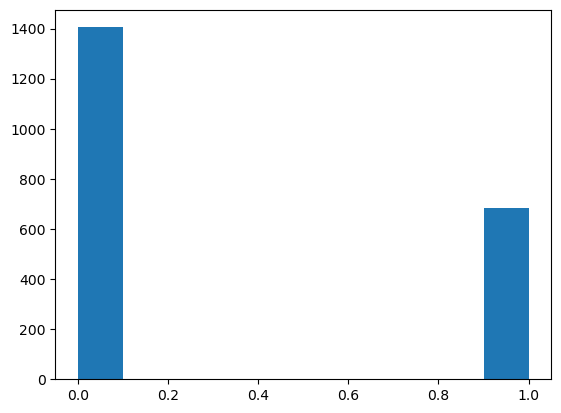

In [16]:
#checking the label data distribution
plt.hist(df['Default'])

# Splitting the data and uploading to S3

In [28]:
train_data, validation_data, test_data = np.split(
    df.sample(frac=1, random_state=0),
    [int(0.7 * len(df)), int(0.9 * len(df))],
)
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)


(1463, 31)
(418, 31)
(209, 31)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


"\nimport pandas as pd\n\n# Assuming 'df' is your pandas DataFrame\n# Shuffle the DataFrame\ndf_shuffled = df.sample(frac=1, random_state=42)\n\n# Calculate split indices\ntrain_end_idx = int(0.7 * len(df_shuffled))\nvalidation_end_idx = int(0.9 * len(df_shuffled))\n\n# Split the DataFrame\ntrain_data = df_shuffled[:train_end_idx]\nvalidation_data = df_shuffled[train_end_idx:validation_end_idx]\ntest_data = df_shuffled[validation_end_idx:]\n\n# Print shapes\nprint(train_data.shape)\nprint(validation_data.shape)\nprint(test_data.shape)\n"

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 233 to 780
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Default            1463 non-null   int64  
 1   City               1463 non-null   object 
 2   State              1463 non-null   object 
 3   Zip                1463 non-null   int64  
 4   Bank               1463 non-null   object 
 5   BankState          1463 non-null   object 
 6   NAICS              1463 non-null   int64  
 7   ApprovalDate       1463 non-null   int64  
 8   ApprovalFY         1463 non-null   int64  
 9   Term               1463 non-null   int64  
 10  NoEmp              1463 non-null   int64  
 11  NewExist           1463 non-null   float64
 12  CreateJob          1463 non-null   int64  
 13  RetainedJob        1463 non-null   int64  
 14  FranchiseCode      1463 non-null   int64  
 15  UrbanRural         1463 non-null   int64  
 16  RevLineCr          1463 non-

### Assuming target column name  is the name of our first column, which is our target variable

In [30]:
# we save the train validation and test frames as csv files


train_data.to_csv("train.csv", index=False)


validation_data.to_csv("validation.csv", index=False)

test_y = test_data['Default']  # This extracts the target column
test_X = test_data.drop(columns=['Default'])  # This drops the target column from the test data

# Now, saving them to CSV files without the index
test_y.to_csv("test_y.csv", index=False)
test_X.to_csv("test_X.csv", index=False)


In [31]:
test_data.head()

,Default,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx
1381,1,LAGUNA NIGUEL,CA,92677,CALIFORNIA BANK TRUST,CA,53,15561,2002,13,...,CHGOFF,47142,150000,127500,0,0,0.85,0,390,15973.0
111,0,CLOVIS,CA,93611,CALIFORNIA BANK TRUST,CA,53,13676,1997,300,...,P I F,0,302000,226500,0,1,0.75,0,9000,23425.0
166,1,SACRAMENTO,CA,95825,BANK OF AMERICA NATL ASSOC,NC,53,16762,2006,51,...,CHGOFF,50000,50000,25000,0,0,0.50,0,1530,18331.0
779,1,OXNARD,CA,93030,CAPITAL ONE NATL ASSOC,VA,53,17444,2008,67,...,CHGOFF,28276,35000,17500,0,0,0.50,0,2010,19510.0
207,0,OAKDALE,CA,95361,BANK OF AMERICA NATL ASSOC,NC,53,16860,2006,84,...,P I F,0,100000,50000,0,0,0.50,0,2520,19411.0


In [32]:
# We upload those csv files to the s3 
!aws s3 cp ./train.csv s3://pipelining/Training/train.csv
!aws s3 cp ./validation.csv s3://pipelining/Validation/validatioan.csv
!aws s3 cp ./test_X.csv s3://pipelining/Testing/test_X.csv
!aws s3 cp ./test_y.csv s3://pipelining/Testing/test_y.csv


upload: ./train.csv to s3://pipelining/Training/train.csv           
upload: ./validation.csv to s3://pipelining/Validation/validatioan.csv
upload: ./test_X.csv to s3://pipelining/Testing/test_X.csv        
upload: ./test_y.csv to s3://pipelining/Testing/test_y.csv        


# Hyperparameter Tuning

In [33]:
#setting hyper parameter tuning job config
from time import gmtime, strftime, sleep

tuning_job_name = "xgboost-tuningjob-" + strftime("%d-%H-%M-%S", gmtime())

print(tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",
            },
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "max_depth",
            }
        ],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 11, "MaxParallelTrainingJobs": 2},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:logloss", "Type": "Minimize"},
}

xgboost-tuningjob-10-04-29-33


In [34]:
#Training job definition for HPO

bucket = 'pipelining'
prefix = ''
#from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve
training_image = retrieve(framework="xgboost", region=region, version="1.7-1")

s3_input_train = "s3://{}/Training".format(bucket)
s3_input_validation = "s3://{}/Validation/".format(bucket)

#sagemaker_client = boto3.client('sagemaker')
#s3_client = boto3.client('s3')


training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/output".format(bucket)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "StaticHyperParameters": {
        "eval_metric": "auc",
        "num_round": "100",
        #"objective": "binary:hinge",
        "objective": "binary:logistic",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}


In [35]:
# we create the HPO job
smclient = boto3.Session().client("sagemaker")

smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:490656968305:hyper-parameter-tuning-job/xgboost-tuningjob-10-04-29-33',
 'ResponseMetadata': {'RequestId': '2af6b343-a24b-40e9-b41d-8e0f2a33f621',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2af6b343-a24b-40e9-b41d-8e0f2a33f621',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Wed, 10 Apr 2024 04:29:42 GMT'},
  'RetryAttempts': 0}}

In [39]:
# show state
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)[
    "HyperParameterTuningJobStatus"]

'Completed'

In [40]:
# we find the best training job out of the 11 completed
from pprint import pprint

# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)
if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2024, 4, 10, 4, 34, 51, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:logloss',
                                                 'Value': 0.06712999939918518},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 4, 10, 4, 35, 31, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:490656968305:training-job/xgboost-tuningjob-10-04-29-33-008-9102068f',
 'TrainingJobName': 'xgboost-tuningjob-10-04-29-33-008-9102068f',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 4, 10, 4, 34, 54, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.7206201032564015',
                          'eta': '0.522315287691574',
                          'max_depth': '4',
                          'min_child_weight': '9.483273644653213'}}


# Hosting

In [61]:

from sagemaker.image_uris import retrieve

# Now we choose the best training job resulted in HPO
TrainingJobName = 'xgboost-tuningjob-10-04-29-33-008-9102068f'

#Now that we've trained the algorithm on our data, let's setup a model which can later be hosted.  We will:
#1. Point to the scoring container
#1. Point to the model.tar.gz that came from training
#1. Create the hosting model

container = retrieve(framework="xgboost", region=region, version="1.7-1")

sm_client = boto3.client('sagemaker', region_name=region)
xgboost_hosting_container = {
    "Image": container,
    "ModelDataUrl": sm_client.describe_training_job(TrainingJobName=TrainingJobName)\
    ["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm_client.create_model(
    ModelName=TrainingJobName, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container
)

print(create_model_response["ModelArn"])


# second endpoint config

'''
# Now we choose the best training job resulted in HPO
TrainingJobName2 = 'xgboost-tuningjob-10-04-29-33-002-a3f02998'

#Now that we've trained the algorithm on our data, let's setup a model which can later be hosted.  We will:
#1. Point to the scoring container
#1. Point to the model.tar.gz that came from training
#1. Create the hosting model

container2 = retrieve(framework="xgboost", region=region, version="1.0-1")

sm_client = boto3.client('sagemaker', region_name=region)
xgboost_hosting_container = {
    "Image": container,
    "ModelDataUrl": sm_client.describe_training_job(TrainingJobName=TrainingJobName2)\
    ["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm_client.create_model(
    ModelName=TrainingJobName, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container
)

print(create_model_response["ModelArn"])

'''

'\n# Now we choose the best training job resulted in HPO\nTrainingJobName2 = \'xgboost-tuningjob-10-04-29-33-002-a3f02998\'\n\n#Now that we\'ve trained the algorithm on our data, let\'s setup a model which can later be hosted.  We will:\n#1. Point to the scoring container\n#1. Point to the model.tar.gz that came from training\n#1. Create the hosting model\n\ncontainer2 = retrieve(framework="xgboost", region=region, version="1.0-1")\n\nsm_client = boto3.client(\'sagemaker\', region_name=region)\nxgboost_hosting_container = {\n    "Image": container,\n    "ModelDataUrl": sm_client.describe_training_job(TrainingJobName=TrainingJobName2)    ["ModelArtifacts"][\n        "S3ModelArtifacts"\n    ],\n}\n\ncreate_model_response = sm_client.create_model(\n    ModelName=TrainingJobName, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container\n)\n\nprint(create_model_response["ModelArn"])\n\n'

# Checkpoint!

In [8]:
TrainingJobName = 'xgboost-tuningjob-10-04-29-33-008-9102068f'

In [9]:
#endpoint config

import time
xgboost_endpoint_config = "xgboost-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(xgboost_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
            "ModelName": TrainingJobName,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

xgboost-endpoint-config-2024-04-16-04-15-59
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:490656968305:endpoint-config/xgboost-endpoint-config-2024-04-16-04-15-59


In [4]:
import time
from time import gmtime, strftime, sleep
from datetime import datetime
sm = boto3.Session().client("sagemaker")



# Creating endpoint

In [10]:
ep_config_name = xgboost_endpoint_config

endpoint_name = f"DEMO-Deployment-Guardrails-Canary-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Endpoint Name: {endpoint_name}")

resp = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=ep_config_name)
print(f"\nCreated Endpoint: {resp}")

Endpoint Name: DEMO-Deployment-Guardrails-Canary-2024-04-16-04-16-12

Created Endpoint: {'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-16-04-16-12', 'ResponseMetadata': {'RequestId': 'c0b21ccc-3523-4ce7-9bfa-89ad492c413e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c0b21ccc-3523-4ce7-9bfa-89ad492c413e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '121', 'date': 'Tue, 16 Apr 2024 04:16:12 GMT'}, 'RetryAttempts': 0}}


In [11]:
#checking for endpoint creation
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service
...
Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-16-04-16-12',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-16-04-16-12',
 'EndpointConfigName': 'xgboost-endpoint-config-2024-04-16-04-15-59',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:777ccd0b2d755ce43c310d8ee37502e51342f243279ae400cafe6b54b32dd271',
     'ResolutionTime': datetime.datetime(2024, 4, 16, 4, 16, 13, 399000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 16, 4, 16, 12, 824000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 16, 4, 19, 8, 562000, tzinfo=tzloc

In [13]:
endpoint_name  = "DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04"

# Sending Input columns for Inferencing

In [14]:
sm_runtime = boto3.Session().client("sagemaker-runtime")


In [16]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_X_numeric.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
            count += 1
            if count > max_invocations:
                break
            time.sleep(wait_interval_sec)

    print("\nDone!")


invoke_endpoint(endpoint_name, max_invocations=50)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04. 
Please wait...
...................................................
Done!


In [18]:
from sagemaker.image_uris import retrieve

In [46]:
image_uri1 = retrieve("xgboost", boto3.Session().region_name, "0.90-2")
image_uri2 = retrieve("xgboost", boto3.Session().region_name, "1.2-1")
image_uri3 = retrieve("xgboost", boto3.Session().region_name, "0.90-1")

print(f"Model Image 2: {image_uri1}")
print(f"Model Image 2: {image_uri2}")
print(f"Model Image 3: {image_uri3}")

Model Image 2: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3
Model Image 2: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1
Model Image 3: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3


In [20]:
TrainingJobName2 = "xgboost-tuningjob-16-01-05-42-002-1ba4cd90"


In [22]:
 model_url2 = sm.describe_training_job(TrainingJobName=TrainingJobName2)\
    ["ModelArtifacts"][
        "S3ModelArtifacts"]


In [23]:
model_url2

's3://pipelining/output/xgboost-tuningjob-16-01-05-42-002-1ba4cd90/output/model.tar.gz'

In [51]:
model_name1 = f"DEMO-xgb-pred1-{datetime.now():%Y-%m-%d-%H-%M-%S}"



print(f"Model Name 1: {model_name1}")




resp = sm.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri1, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")



Model Name 1: DEMO-xgb-pred1-2024-04-16-05-04-20
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:490656968305:model/DEMO-xgb-pred1-2024-04-16-05-04-20', 'ResponseMetadata': {'RequestId': '4e135c51-e9ed-4dc5-b7f0-f895fa4a8b41', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4e135c51-e9ed-4dc5-b7f0-f895fa4a8b41', 'content-type': 'application/x-amz-json-1.1', 'content-length': '96', 'date': 'Tue, 16 Apr 2024 05:04:21 GMT'}, 'RetryAttempts': 0}}


In [39]:



model_name2 = f"DEMO-xgb-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"DEMO-xgb-pred3-{datetime.now():%Y-%m-%d-%H-%M-%S}"


print(f"Model Name 2: {model_name2}")
print(f"Model Name 3: {model_name3}")



resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri2, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri3, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")


Model Name 2: DEMO-xgb-pred2-2024-04-16-04-46-15
Model Name 3: DEMO-xgb-pred3-2024-04-16-04-46-15
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:490656968305:model/DEMO-xgb-pred2-2024-04-16-04-46-15', 'ResponseMetadata': {'RequestId': 'e7322647-d41c-4b33-bce3-80b47aa72bc5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'e7322647-d41c-4b33-bce3-80b47aa72bc5', 'content-type': 'application/x-amz-json-1.1', 'content-length': '96', 'date': 'Tue, 16 Apr 2024 04:46:15 GMT'}, 'RetryAttempts': 0}}
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:490656968305:model/DEMO-xgb-pred3-2024-04-16-04-46-15', 'ResponseMetadata': {'RequestId': '2e6f8913-8899-416d-943f-d979fe43ef34', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2e6f8913-8899-416d-943f-d979fe43ef34', 'content-type': 'application/x-amz-json-1.1', 'content-length': '96', 'date': 'Tue, 16 Apr 2024 04:46:20 GMT'}, 'RetryAttempts': 3}}


'\n\nsm_client = boto3.client(\'sagemaker\', region_name=region)\nxgboost_hosting_container = {\n    "Image": container,\n    "ModelDataUrl": sm_client.describe_training_job(TrainingJobName=TrainingJobName)    ["ModelArtifacts"][\n        "S3ModelArtifacts"\n    ],\n}\n\ncreate_model_response = sm_client.create_model(\n    ModelName=TrainingJobName, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container\n)\n'

In [52]:
ep_config_name1 = f"DEMO-EpConfig-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 2: {ep_config_name2}")


resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name1,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name1,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

Endpoint Config 2: DEMO-EpConfig-2-2024-04-16-04-46-35
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint-config/DEMO-EpConfig-1-2024-04-16-05-04-33', 'ResponseMetadata': {'RequestId': '45f2903e-026a-4e05-b35c-3f54fafbbd4a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '45f2903e-026a-4e05-b35c-3f54fafbbd4a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Tue, 16 Apr 2024 05:04:33 GMT'}, 'RetryAttempts': 0}}


In [40]:
ep_config_name2 = f"DEMO-EpConfig-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name3 = f"DEMO-EpConfig-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 2: {ep_config_name2}")
print(f"Endpoint Config 3: {ep_config_name3}")


resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name2,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name2,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

Endpoint Config 2: DEMO-EpConfig-2-2024-04-16-04-46-35
Endpoint Config 3: DEMO-EpConfig-3-2024-04-16-04-46-35
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint-config/DEMO-EpConfig-2-2024-04-16-04-46-35', 'ResponseMetadata': {'RequestId': 'c0a8ce8a-38d1-4bbb-b9c6-9d32afd78216', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c0a8ce8a-38d1-4bbb-b9c6-9d32afd78216', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Tue, 16 Apr 2024 04:46:35 GMT'}, 'RetryAttempts': 0}}
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint-config/DEMO-EpConfig-3-2024-04-16-04-46-35', 'ResponseMetadata': {'RequestId': '401a2cb1-f255-4628-b980-730d84c5a866', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '401a2cb1-f255-4628-b980-730d84c5a866', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Tue, 16 Apr 2024 04:46:41 GMT'}, 'RetryAttem

# Testing the endpoint through invoking

In [26]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_X_numeric.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
            count += 1
            if count > max_invocations:
                break
            time.sleep(wait_interval_sec)

    print("\nDone!")


invoke_endpoint(endpoint_name, max_invocations=30)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04. 
Please wait...
...............................
Done!


# Failed Update rollback activation

In [27]:
cw = boto3.Session().client("cloudwatch", region_name=region)

In [28]:
def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [29]:
error_alarm = f"TestAlarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"

# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 1
)
# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000
)

In [41]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT",  # or use "CAPACITY_PERCENT" as 30%, 50%
                "Value": 1,
            },
            "WaitIntervalInSeconds": 300,  # wait for 5 minutes before enabling traffic on the rest of fleet
        },
        "TerminationWaitInSeconds": 120,  # wait for 2 minutes before terminating the old stack
        "MaximumExecutionTimeoutInSeconds": 1800,  # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}],
    },
}

# update endpoint request with new DeploymentConfig parameter
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name2,
    DeploymentConfig=canary_deployment_config,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04',
 'ResponseMetadata': {'RequestId': 'efc1f776-b44c-4962-b4a9-029e9f79610f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'efc1f776-b44c-4962-b4a9-029e9f79610f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Tue, 16 Apr 2024 04:47:08 GMT'},
  'RetryAttempts': 0}}

In [42]:
invoke_endpoint(endpoint_name, max_invocations=600)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04. 
Please wait...
.....................................................................................................................................................................................EE.E....EEE...E..EE.E.EEE...
Done!


In [43]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04',
 'EndpointConfigName': 'DEMO-EpConfig-3-2024-04-16-01-45-51',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2024, 4, 16, 3, 54, 28, 126000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-ModelLatency-DEMO-Deployment-Guardrails-Canary-2024-04-

# Successful Update

In [54]:
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name1,
    DeploymentConfig=canary_deployment_config,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04',
 'ResponseMetadata': {'RequestId': 'ee8674dc-ce78-48b7-aa13-93bef81a3609',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ee8674dc-ce78-48b7-aa13-93bef81a3609',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Tue, 16 Apr 2024 05:05:57 GMT'},
  'RetryAttempts': 0}}

In [55]:
invoke_endpoint(endpoint_name, max_invocations=600)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04. 
Please wait...
.................................................................................................................................................................................................................
Done!


In [56]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-15-18-01-04',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-04-16-05-04-33',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:0d098653ff2915993d61180da0cde0ed982805093463d40f30212b8050486f18',
     'ResolutionTime': datetime.datetime(2024, 4, 16, 5, 5, 58, 380000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 15, 18, 1, 4, 550000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 16, 5, 15, 41, 363000, tzinfo=tzloc

# Hyperparameter tuning

In [137]:
#Upadating csv files
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import boto3
from io import StringIO

# Setup
s3 = boto3.client('s3')
bucket = 'pipelining'
prefix = ''

# Function to convert categorical columns to numerical
def encode_and_save(file_key, output_key):
    response = s3.get_object(Bucket=bucket, Key=file_key)
    df = pd.read_csv(response['Body'])

    label_encoder = LabelEncoder()
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = label_encoder.fit_transform(df[column])

    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3.put_object(Bucket=bucket, Key=output_key, Body=csv_buffer.getvalue())

# Encode and save training data
encode_and_save(f"{prefix}Training/train.csv", f"{prefix}Training/numerical_training.csv")

# Encode and save validation data
encode_and_save(f"{prefix}Validation/validatioan.csv", f"{prefix}Validation/numerical_validation.csv")


In [138]:
#setting hyper parameter tuning job config
from time import gmtime, strftime, sleep

tuning_job_name = "xgboost-tuningjob-" + strftime("%d-%H-%M-%S", gmtime())

print(tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",
            },
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "max_depth",
            }
        ],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 5, "MaxParallelTrainingJobs": 2},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:logloss", "Type": "Minimize"},
}

xgboost-tuningjob-16-01-05-42


In [139]:
#Training job definition for HPO

bucket = 'pipelining'
prefix = ''
#from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve
training_image = retrieve(framework="xgboost", region=region, version="0.90-1")

s3_input_train = "s3://{}/Training/numerical_training.csv".format(bucket)
s3_input_validation = "s3://{}/Validation/numerical_validation.csv".format(bucket)

#sagemaker_client = boto3.client('sagemaker')
#s3_client = boto3.client('s3')


training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/output".format(bucket)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "StaticHyperParameters": {
        "eval_metric": "auc",
        "num_round": "100",
        #"objective": "binary:hinge",
        "objective": "binary:logistic",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}


In [140]:
# we create the HPO job
smclient = boto3.Session().client("sagemaker")

smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:490656968305:hyper-parameter-tuning-job/xgboost-tuningjob-16-01-05-42',
 'ResponseMetadata': {'RequestId': 'c715ddb7-ea25-4682-bc0b-625fa528b67e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c715ddb7-ea25-4682-bc0b-625fa528b67e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Tue, 16 Apr 2024 01:05:50 GMT'},
  'RetryAttempts': 0}}

# Shadow Testing

In [ ]:
image_uri1 = retrieve("xgboost", boto3.Session().region_name, "0.90-2")
image_uri3 = retrieve("xgboost", boto3.Session().region_name, "0.90-1")


print(f"Model Image 1: {image_uri1}")
print(f"Model Image 2: {image_uri3}")

In [64]:
print(model_name1)
model_name3


DEMO-xgb-pred1-2024-04-16-05-04-20


'DEMO-xgb-pred3-2024-04-16-04-46-15'

In [65]:
endpoint_config_name = f"Shadowtesting-{datetime.now():%Y-%m-%d-%H-%M-%S}"

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "Productionvariant",
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ],
    ShadowProductionVariants=[
        {
            "VariantName": "Shadowvariant",
            "ModelName": model_name1,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
   ]
)
                

In [66]:
create_endpoint_response = sm.create_endpoint(
    EndpointName="Shadowtesting",
    EndpointConfigName=endpoint_config_name,
)
                

In [69]:
sm.describe_endpoint(EndpointName="Shadowtesting")

{'EndpointName': 'Shadowtesting',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/Shadowtesting',
 'EndpointConfigName': 'Shadowtesting-2024-04-16-06-03-28',
 'ProductionVariants': [{'VariantName': 'Productionvariant',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2024, 4, 16, 6, 5, 38, 736000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 16, 6, 5, 37, 974000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 16, 6, 8, 13, 608000, tzinfo=tzlocal()),
 'ShadowProductionVariants': [{'VariantName': 'Shadowvariant',
   'De

In [72]:
%%time
invoke_endpoint(endpoint_name="Shadowtesting", max_invocations=30)

Sending test traffic to the endpoint Shadowtesting. 
Please wait...
...............................
Done!
CPU times: user 101 ms, sys: 14.1 ms, total: 115 ms
Wall time: 30.4 s


In [74]:
response = sm.update_endpoint_weights_and_capacities(
    EndpointName="Shadowtesting",
    DesiredWeightsAndCapacities=[
        {
            "VariantName": "Productionvariant",
            "DesiredWeight": 1
        },
        {
            "VariantName": "Shadowvariant",
            "DesiredWeight": 0
        }
    ]
)

print("Updated weights. Traffic now directed to the production variant.")


Updated weights. Traffic now directed to the production variant.


In [75]:
%%time
invoke_endpoint(endpoint_name="Shadowtesting", max_invocations=30)

Sending test traffic to the endpoint Shadowtesting. 
Please wait...
...............................
Done!
CPU times: user 113 ms, sys: 11.9 ms, total: 125 ms
Wall time: 30.5 s


In [79]:
response = sm.update_endpoint_weights_and_capacities(
    EndpointName="Shadowtesting",
    DesiredWeightsAndCapacities=[
        {
            "VariantName": "Productionvariant",
            "DesiredWeight": 0
        },
        {
            "VariantName": "Shadowvariant",
            "DesiredWeight": 1
        }
    ]
)

print("Updated weights. Traffic now directed to the production variant.")


Updated weights. Traffic now directed to the production variant.


In [80]:
%%time
invoke_endpoint(endpoint_name="Shadowtesting", max_invocations=30)

Sending test traffic to the endpoint Shadowtesting. 
Please wait...
...............................
Done!
CPU times: user 96 ms, sys: 18.2 ms, total: 114 ms
Wall time: 30.4 s


In [82]:
endpoint_config_name_new = f"Shadowtesting-{datetime.now():%Y-%m-%d-%H-%M-%S}"

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name_new,
    ProductionVariants=[
        {
            "VariantName": "Productionvariant",
            "ModelName": model_name1,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ]
)

In [85]:
sm.update_endpoint(
    EndpointName="Shadowtesting",
    EndpointConfigName=endpoint_config_name_new,
    
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:490656968305:endpoint/Shadowtesting',
 'ResponseMetadata': {'RequestId': '5fa1bfb5-b9b6-4a46-8a79-cc0ed31b2b16',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5fa1bfb5-b9b6-4a46-8a79-cc0ed31b2b16',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Tue, 16 Apr 2024 06:36:28 GMT'},
  'RetryAttempts': 0}}